In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from tqdm.auto import tqdm

from matplotlib import cm
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

jet = cm.get_cmap('jet')

/tmp/ipykernel_35259/1764591451.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap('jet')


# Optimization for some chosen Y (no l2 normalization)

In [2]:
Y = torch.tensor([[1,0,0,0],
                  [1,1,1,0],
                  [0,0,1,0],
                  [0,1,0,1]])

Y = torch.unique(Y, dim=-1)
Y = Y.repeat_interleave(torch.randint(4, 7, size=(Y.shape[-1],)), dim=1)

u, labels = torch.unique(Y, dim=-1, return_inverse=True)
labels = labels / labels.max()

c, n = Y.shape

X = torch.normal(0, 0.01, size=(n, 8), requires_grad=True)
norm = torch.ones(size=(n,), requires_grad=True)

alpha = 0.9
beta  = 0.9
tau = 1.0
niter = 1200
device = "cpu"

optimizer = optim.Adam([X, norm], lr=0.001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.998)

tracker = {'loss' : [], 'x_svals' : []}
bar = tqdm(total=niter, dynamic_ncols=True, desc='Train')

X = X.to(device)
Y = Y.to(device)
norm = norm.to(device)

for i in range(niter):
    optimizer.zero_grad()

    #K = norm.reshape(-1,1) * torch.exp(-(torch.cdist(X, X, p=2)**2) / tau) * norm.reshape(1,-1)

    K = X @ X.T
    z_svals = torch.sqrt(F.relu(torch.real(torch.linalg.eigvals(Y.T @ Y + K))))
    x_svals = torch.sqrt(F.relu(torch.real(torch.linalg.eigvals(K))))
    z_nuc = z_svals.sum()
    x_nuc = x_svals.sum()

    loss = z_nuc - alpha * x_nuc + beta * x_svals.max() ** 2

    loss.backward()
    tracker['loss'].append(loss.detach().item())
    tracker['x_svals'].append(x_svals.detach().sort()[0])
    optimizer.step()
    scheduler.step()
    bar.set_postfix(loss="{:1.5e}".format(loss.detach().item()),
                    tau="f{:1.3e}".format(tau),
                    lr="{:1.3e}".format(scheduler.optimizer.param_groups[0]['lr']))
    bar.update()
bar.close()

Train:   0%|          | 0/1200 [00:00<?, ?it/s]

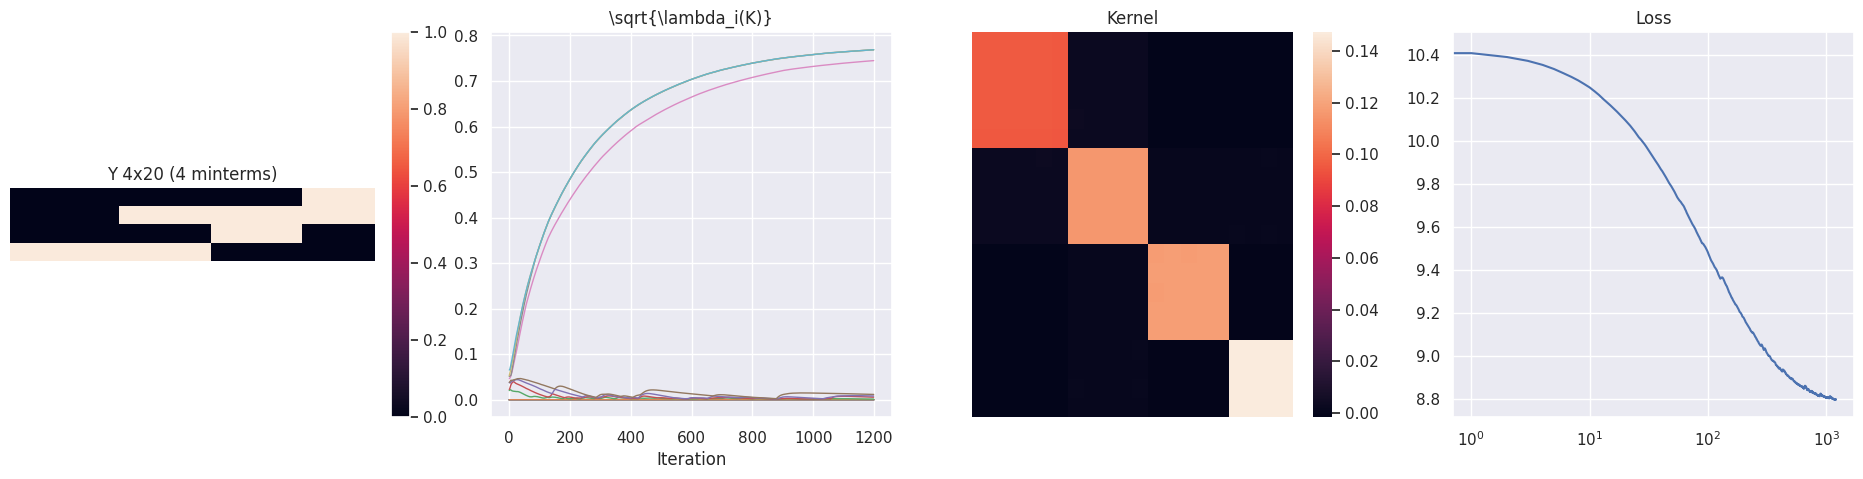

In [3]:
Y_ = Y.detach().cpu()
X_ = X.detach().cpu().T
K = X @ X.T
K_ = K.detach().cpu()
svals_ = torch.stack(tracker['x_svals'], dim=0).detach().cpu()
Z_ = torch.cat((Y_,X_), dim=0)

fig = plt.figure(figsize=(30,5))
plt.subplot(1,5,1)
plt.imshow(Y_)
plt.axis("off")
plt.title(f"Y {Y_.shape[0]}x{Y_.shape[1]} ({u.shape[1]} minterms)")
plt.subplot(1,5,2)
for j in range(svals_.shape[1]):
    plt.plot(svals_[:,j], '-', linewidth=1.0)
plt.title("\sqrt{\lambda_i(K)}")
plt.xlabel("Iteration")
plt.subplot(1,5,3)
sns.heatmap(K_)
plt.colorbar(fraction=0.05, pad=0.04)
plt.axis("off")
plt.title("Kernel")
plt.subplot(1,5,4)
plt.plot(tracker["loss"])
plt.xscale("log")
plt.title("Loss")
plt.show()

In [10]:
torch.real(torch.linalg.eigvals(K))

tensor([ 5.5482e-01,  5.9093e-01,  5.9084e-01,  5.9088e-01,  1.3610e-04,
         6.7376e-05,  3.1544e-05,  2.0152e-06, -2.3827e-08, -1.8702e-08,
         2.4777e-08, -1.0589e-08,  7.0457e-10,  7.0457e-10,  4.6105e-10,
         1.0162e-08,  1.0162e-08,  9.8264e-09,  9.8264e-09,  5.8549e-09],
       grad_fn=<SelectBackward0>)

In [6]:
torch.real(torch.linalg.svdvals(K))

tensor([5.9093e-01, 5.9088e-01, 5.9084e-01, 5.5482e-01, 1.3610e-04, 6.7384e-05,
        3.1548e-05, 2.0101e-06, 3.5200e-08, 3.3656e-08, 2.6177e-08, 2.2940e-08,
        1.8694e-08, 1.5096e-08, 1.2592e-08, 8.1185e-09, 7.4866e-09, 4.7089e-09,
        2.1698e-09, 3.4785e-10], grad_fn=<LinalgSvdBackward0>)

In [204]:
from scipy import optimize

mu = torch.linalg.svdvals(Y)
print(mu)
def curve(x):
    x = x[0]
    return [np.array([x / np.sqrt(m**2 + x**2) for m in mu]).sum() - len(mu)*alpha + 2.0 * beta * x]

def grad(x):
    x = x[0]
    return [np.array([m**2 / np.sqrt(m**2 + x**2)**3 for m in mu]).sum() + 2.0 * beta]

sol = optimize.root(curve, [0.0], jac=grad, method='hybr')
print("Singular values according to theory: {}".format(round(sol.x[0], 5)))

tensor([7.3598, 4.1473, 3.0502, 2.3812, 1.9129])
Singular values according to theory: 1.3859


<StemContainer object of 3 artists>

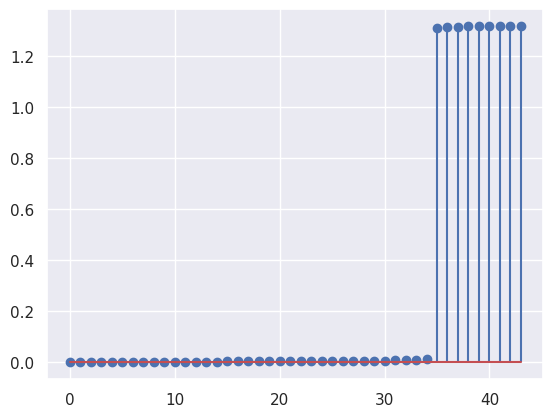

In [206]:
plt.figure()
plt.stem(svals_[-1])